This is the simplest regridding method, and there's an example of it here: http://xarray.pydata.org/en/stable/interpolation.html

In [14]:
# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.crs as crs

# built in python modules
import datetime
import os
import inspect
import sys

# python add-ons
import numpy as np
import pandas as pd
import scipy
import xarray as xr
import netCDF4
from wrf import (to_np, getvar, ALL_TIMES, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import pvlib
import optwrf as ow
from optwrf import runwrf as rw

In [2]:
param_ids = [10, 1, 1, 2, 2, 3, 2]
start_date = 'Feb 7  2011'
end_date = 'Feb 8 2011'
wrf_sim = rw.WRFModel(param_ids, start_date, end_date, 
                      setup_yaml='/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/met4ene/optwrf/optwrf/data/mac_dirpath.yml') 

Forecast starting on: 2011-02-07 00:00:00
Forecast ending on: 2011-02-08 00:00:00


In [3]:
# Process the ERA5 data
#wrf_sim.process_era5_data()

In [4]:
# Find the path to optwrf
optwrf_path = os.path.dirname(os.path.abspath(inspect.getfile(ow)))

In [5]:
in_yr = 2011
in_mo = 2
wrfdir = os.path.join(optwrf_path, 'data/')
eradir = wrf_sim.DIR_ERA5_ROOT

In [17]:
# Find the absolute file path to your pvlib installation
pvlib_abspath = os.path.dirname(os.path.abspath(inspect.getfile(pvlib)))
# Open the NetCDF file
ncfile_orig = os.path.join(pvlib_abspath, 'data', 'wrfout_d01.nc')
# In order for cartopy to access the map projection, we MUST read the dataset in with the netCDF4 package. 
ncdata_orig = netCDF4.Dataset(ncfile_orig)

# WRF file containing source grid
wrffile = 'wrfout_processed_d01.nc'
try:
    wrfdata = xr.open_dataset(wrfdir + wrffile)
except FileNotFoundError:
    print(f'The wrfout file {wrfdir + wrffile} does not exist. Check that your path.')

# Read in and convert GHI from W m-2 to kW m-2
ghi = wrfdata.ghi
ghi = ghi/1000

# Read in WPD, convert from W m-2 to kW m-2
wpd = wrfdata.wpd
wpd = wpd/1000

wrfdata

<xarray.Dataset>
Dimensions:         (Time: 24, bottom_top: 35, south_north: 191, west_east: 191)
Coordinates:
  * Time            (Time) datetime64[ns] 2011-02-07 ... 2011-02-07T23:00:00
    lon             (south_north, west_east) float32 ...
    lat             (south_north, west_east) float32 ...
    wspd_wdir       object ...
    XLONG           (south_north, west_east) float32 ...
    XLAT            (south_north, west_east) float32 ...
    XTIME           (Time) float32 ...
    level           int64 ...
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times           (Time) datetime64[ns] ...
    temp_air        (Time, south_north, west_east) float32 ...
    wind_speed_u    (Time, south_north, west_east) float32 ...
    wind_speed_v    (Time, south_north, west_east) float32 ...
    cloud_fraction  (Time, bottom_top, south_north, west_east) float32 ...
    cos_zenith      (Time, south_north, west_east) float32 ...
    dni             (Time, south_north, west_east) float32 ...
    dhi             (Time, south_north, west_east) float32 ...
    ghi             (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    wind_speed10    (Time, south_north, west_east) float32 ...
    wind_speed100   (Time, south_north, west_east) float32 ...
    wpd             (Time, south_north, west_east) float32 29141.006 ... 7670...

In [7]:
# ERA data file(s)
erafile = f'ERA5_EastUS_WPD-GHI_{str(in_yr).zfill(4)}-{str(in_mo).zfill(2)}.nc'
try:
    eradata = xr.open_dataset(eradir + erafile)
except FileNotFoundError:
    print(f'The wrfout file {eradir + erafile} does not exist. Check that your path.')

# Get variables to compare with regridded WRF variables.
# era_lat = eradata.latitude
# era_lon = eradata.longitude
eradata = eradata.rename({'longitude': 'lon', 'latitude': 'lat'})

# Read in ERA_GHI, convert from W m-2 to kW m-2
era_ghi = eradata.GHI
era_ghi = era_ghi / 1000

# Read in ERA_WPD, convert from W m-2 to kW m-2
era_wpd = eradata.WPD
era_wpd = era_wpd / 1000

# Write these back to the xarray dataset
eradata['ghi'] = era_ghi
eradata['wpd'] = era_wpd

eradata

<xarray.Dataset>
Dimensions:   (Time: 672, lat: 97, lon: 129, time: 672)
Coordinates:
  * lat       (lat) float64 52.0 51.75 51.5 51.25 51.0 ... 28.75 28.5 28.25 28.0
  * lon       (lon) float64 264.0 264.2 264.5 264.8 ... 295.2 295.5 295.8 296.0
  * time      (time) datetime64[ns] 2011-02-01 ... 2011-02-28T23:00:00
  * Time      (Time) datetime64[ns] 2011-02-01 ... 2011-02-28T23:00:00
Data variables:
    VAR_100U  (time, lat, lon) float32 ...
    VAR_100V  (time, lat, lon) float32 ...
    WPD       (time, lat, lon) float32 174317.23 186448.44 ... 324.84235
    SSRD      (Time, lat, lon) float32 ...
    GHI       (Time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ghi       (Time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wpd       (time, lat, lon) float32 174.31723 186.44844 ... 0.32484233

In [19]:
dni_orig = getvar(ncdata_orig, "SWDDNI", timeidx=-1)
# Get the latitude and longitude points
lats, lons = latlon_coords(dni_orig)

# Get the cartopy mapping object
cart_proj = get_cartopy(dni_orig)

In [21]:
dni_orig

<xarray.DataArray 'SWDDNI' (south_north: 191, west_east: 191)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -95.43335 -95.308044 ... -64.11832
    XLAT     (south_north, west_east) float32 30.952759 30.950832 ... 47.507103
    XTIME    float32 1440.0
    Time     datetime64[ns] 2011-02-08
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  Shortwave surface downward direct normal irradiance
    units:        W m-2
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.0, moad_cen_lat=40.259845733...

In [20]:
cart_proj

In [9]:
# Do the regridding


In [10]:
# Add the regridded variables to the WRF xarray dataset
wrfdata['ghi_regrid'] = wrf_ghi_regrid
wrfdata['wpd_regrid'] = wrf_wpd_regrid

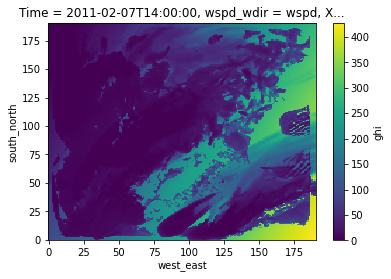

In [11]:
ghi2d = wrfdata.ghi.isel(Time=14)
ghi2d.plot()

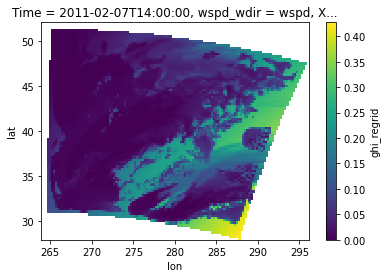

In [12]:
ghi2d = wrfdata.ghi_regrid.isel(Time=14)
ghi2d.plot()

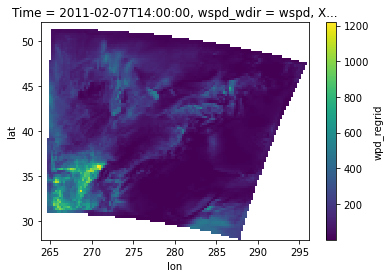

In [13]:
wrf_wpd_regrid
wpd2d = wrfdata.wpd_regrid.isel(Time=14)
wpd2d.plot()

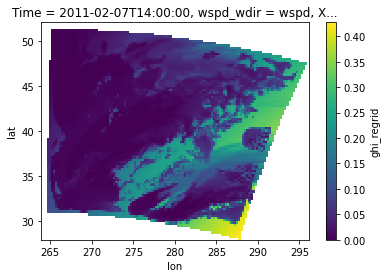

In [29]:
ghi2d = wrfdata_2.ghi_regrid.isel(Time=14)
ghi2d.plot()

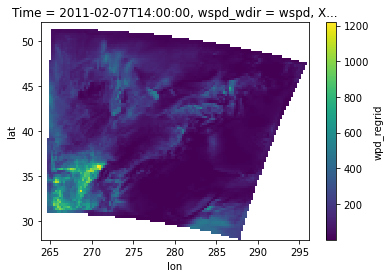

In [30]:
wrf_wpd_regrid
wpd2d = wrfdata_2.wpd_regrid.isel(Time=14)
wpd2d.plot()

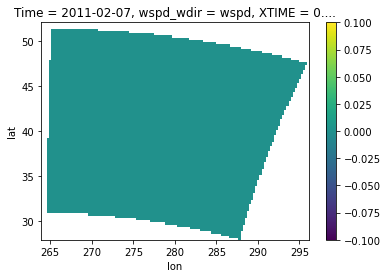

In [37]:
# Compare the manual and hacky bug fix. (All should be nan or 0)
diff = total_ghi_error_man - total_ghi_error_man
diff.plot()

In [48]:
# Get the total error now using the function in optwrf.runwrf
wrfdata_2 = rw.wrf_era5_error(wrfdata_2, eradata_2)
wrfdata_2

<xarray.Dataset>
Dimensions:          (Time: 24, bottom_top: 35, lat: 97, lon: 129, south_north: 191, time: 672, west_east: 191)
Coordinates:
  * Time             (Time) datetime64[ns] 2011-02-07 ... 2011-02-07T23:00:00
  * lon              (lon) float64 264.0 264.2 264.5 264.8 ... 295.5 295.8 296.0
  * lat              (lat) float64 52.0 51.75 51.5 51.25 ... 28.5 28.25 28.0
    wspd_wdir        object ...
    XLONG            (south_north, west_east) float32 ...
    XLAT             (south_north, west_east) float32 ...
    XTIME            (Time) float32 ...
    level            int64 ...
  * time             (time) datetime64[ns] 2011-02-01 ... 2011-02-28T23:00:00
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    Times            (Time) datetime64[ns] ...
    temp_air         (Time, south_north, west_east) float32 ...
    wind_speed_u     (Time, south_north, west_east) float32 ...
    wind_speed_v     (Time, south_north, west_east) float32 ...
    cloud_fraction   (Time, bottom_top, south_north, west_east) float32 ...
    cos_zenith       (Time, south_north, west_east) float32 ...
    dni              (Time, south_north, west_east) float32 ...
    dhi              (Time, south_north, west_east) float32 ...
    ghi              (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    wind_speed10     (Time, south_north, west_east) float32 ...
    wind_speed100    (Time, south_north, west_east) float32 ...
    wpd              (Time, south_north, west_east) float32 29141.006 ... 7670.802
    ghi_regrid       (Time, lat, lon) float64 nan nan nan nan ... nan nan nan
    wpd_regrid       (Time, lat, lon) float64 nan nan nan nan ... nan nan nan
    ghi_error        (Time, lat, lon) float64 nan nan nan nan ... nan nan nan
    wpd_error        (Time, lat, lon, time) float64 nan nan nan ... nan nan nan
    total_ghi_error  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    total_wpd_error  (lat, lon, time) float64 nan nan nan nan ... nan nan nan

In [50]:
error = [0, float(wrfdata_2['total_ghi_error'].sum().values), float(wrfdata_2['total_wpd_error'].sum().values)]
error

[0, 10213.991776451854, 48887860697.26696]

In [51]:
# Annual mean daylight fraction 
daylight_factors = []
for jday in range(1, 366):
    daylight_factors.append(ow.helper_functions.daylight_frac(jday))

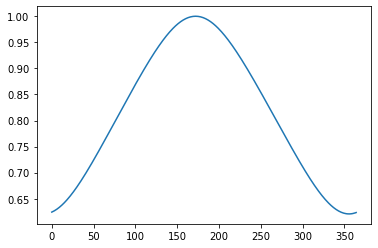

In [52]:
fig, ax = plt.subplots()
ax.plot(daylight_factors)

In [54]:
sum(daylight_factors) / len(daylight_factors)

0.812716796611979